In [3]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing

In [4]:
def f1(x, t):
    return 1.0 / np.cosh(x + 3) * np.cos(2.3 * t)


def f2(x, t):
    return 2.0 / np.cosh(x) * np.tanh(x) * np.sin(2.8 * t)

In [5]:
nx = 65  # number of grid points along space dimension
nt = 129  # number of grid points along time dimension

# Define the space and time grid for data collection.
x = np.linspace(-5, 5, nx)
t = np.linspace(0, 4 * np.pi, nt)
xgrid, tgrid = np.meshgrid(x, t)
dt = t[1] - t[0]  # time step between each snapshot

# Data consists of 2 spatiotemporal signals.
X1 = f1(xgrid, tgrid)
X2 = f2(xgrid, tgrid)
X = X1 + X2

# Make a version of the data with noise.
mean = 0
std_dev = 0.2
random_matrix = np.random.normal(mean, std_dev, size=(nt, nx))
Xn = X + random_matrix

X.shape

(129, 65)

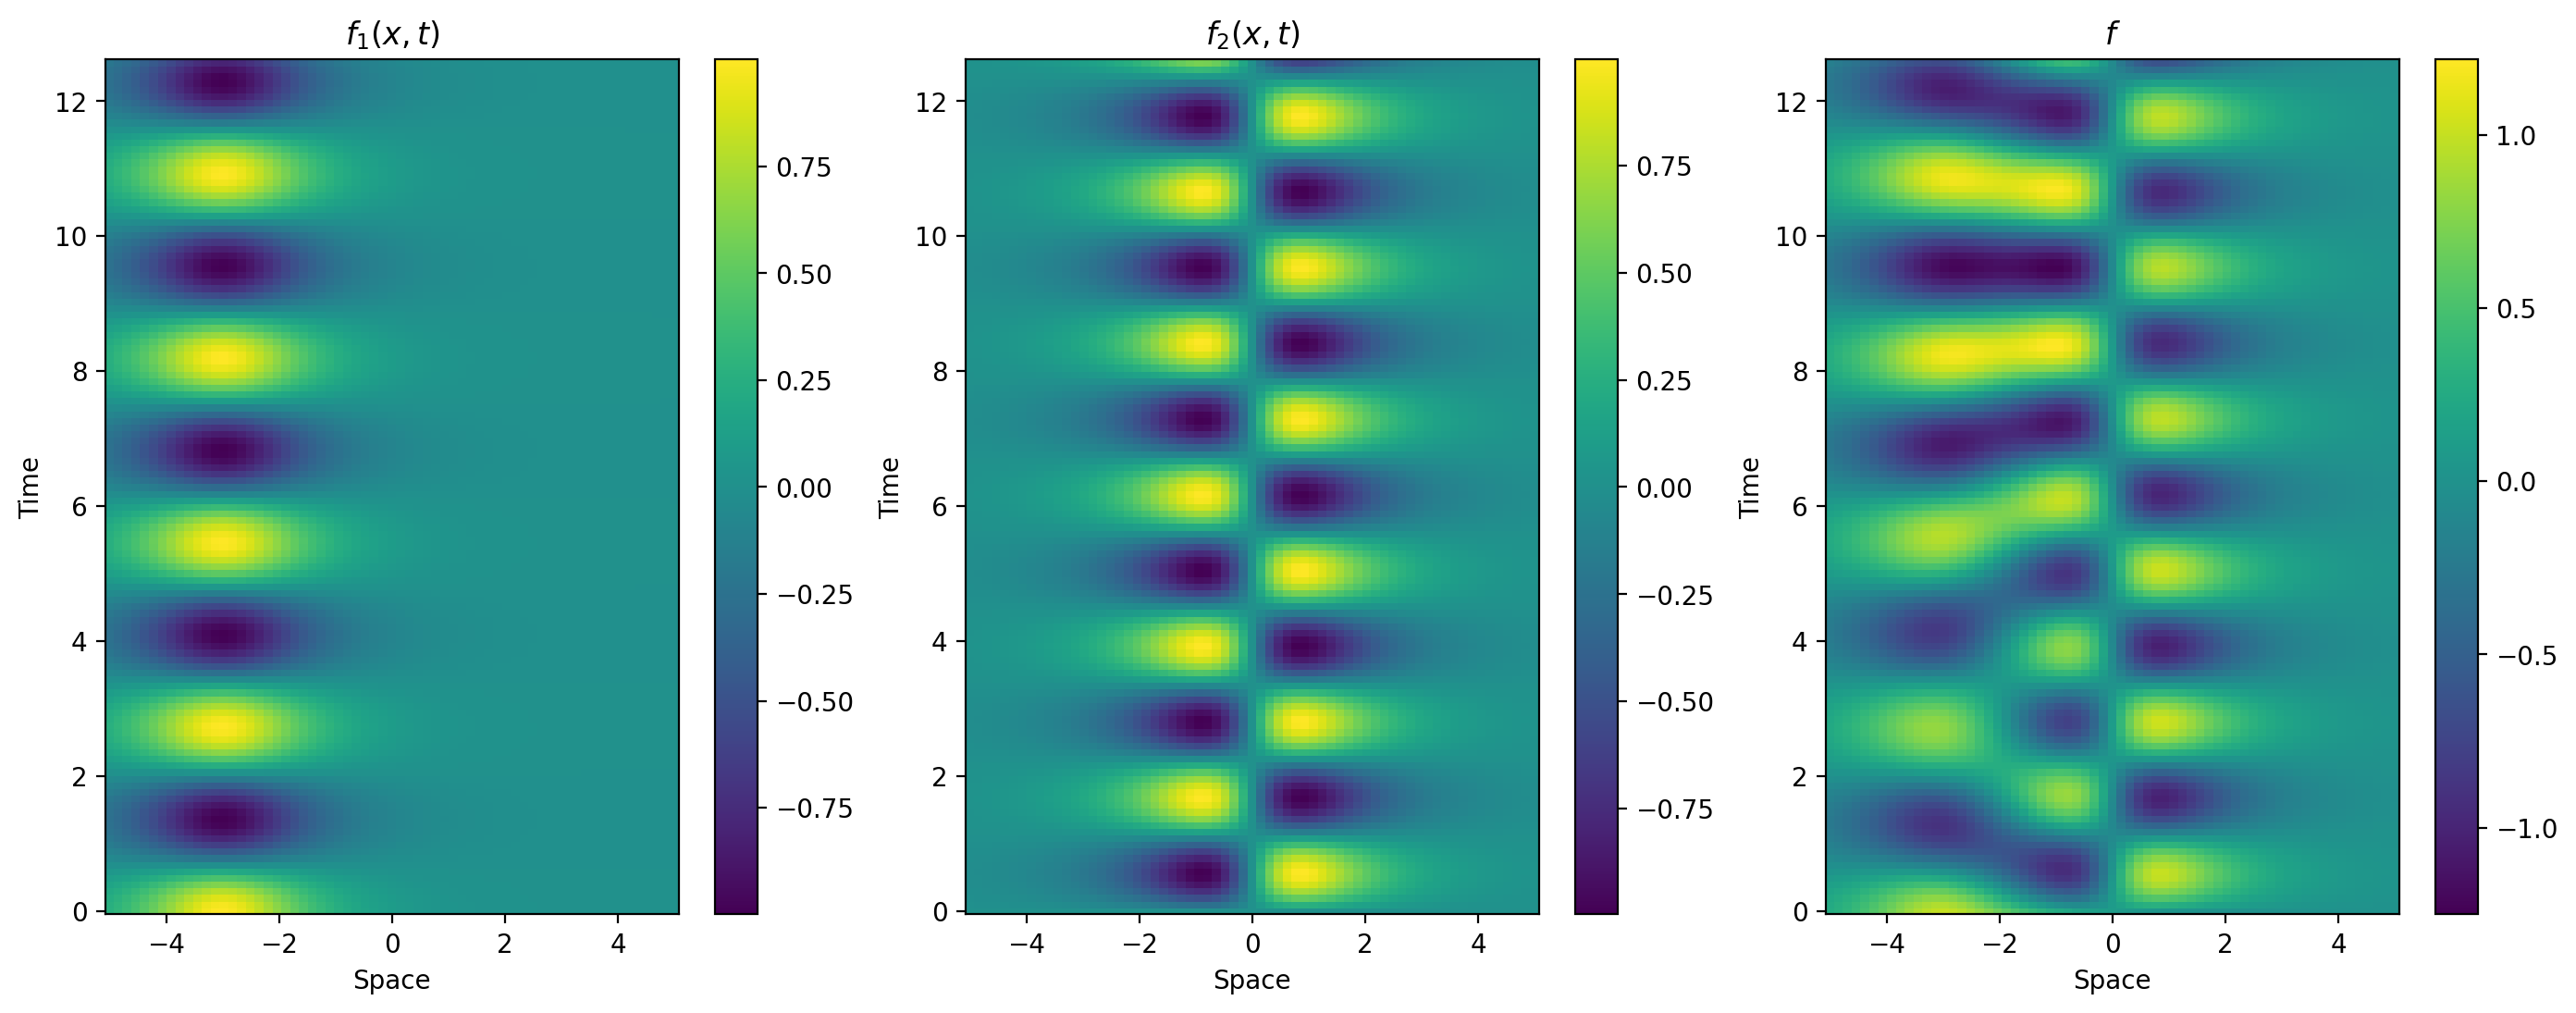

In [6]:
titles = ["$f_1(x,t)$", "$f_2(x,t)$", "$f$"]
data = [X1, X2, X]

fig = plt.figure(figsize=(17, 6), dpi=200)
for n, title, d in zip(range(131, 134), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.colorbar()
plt.show()

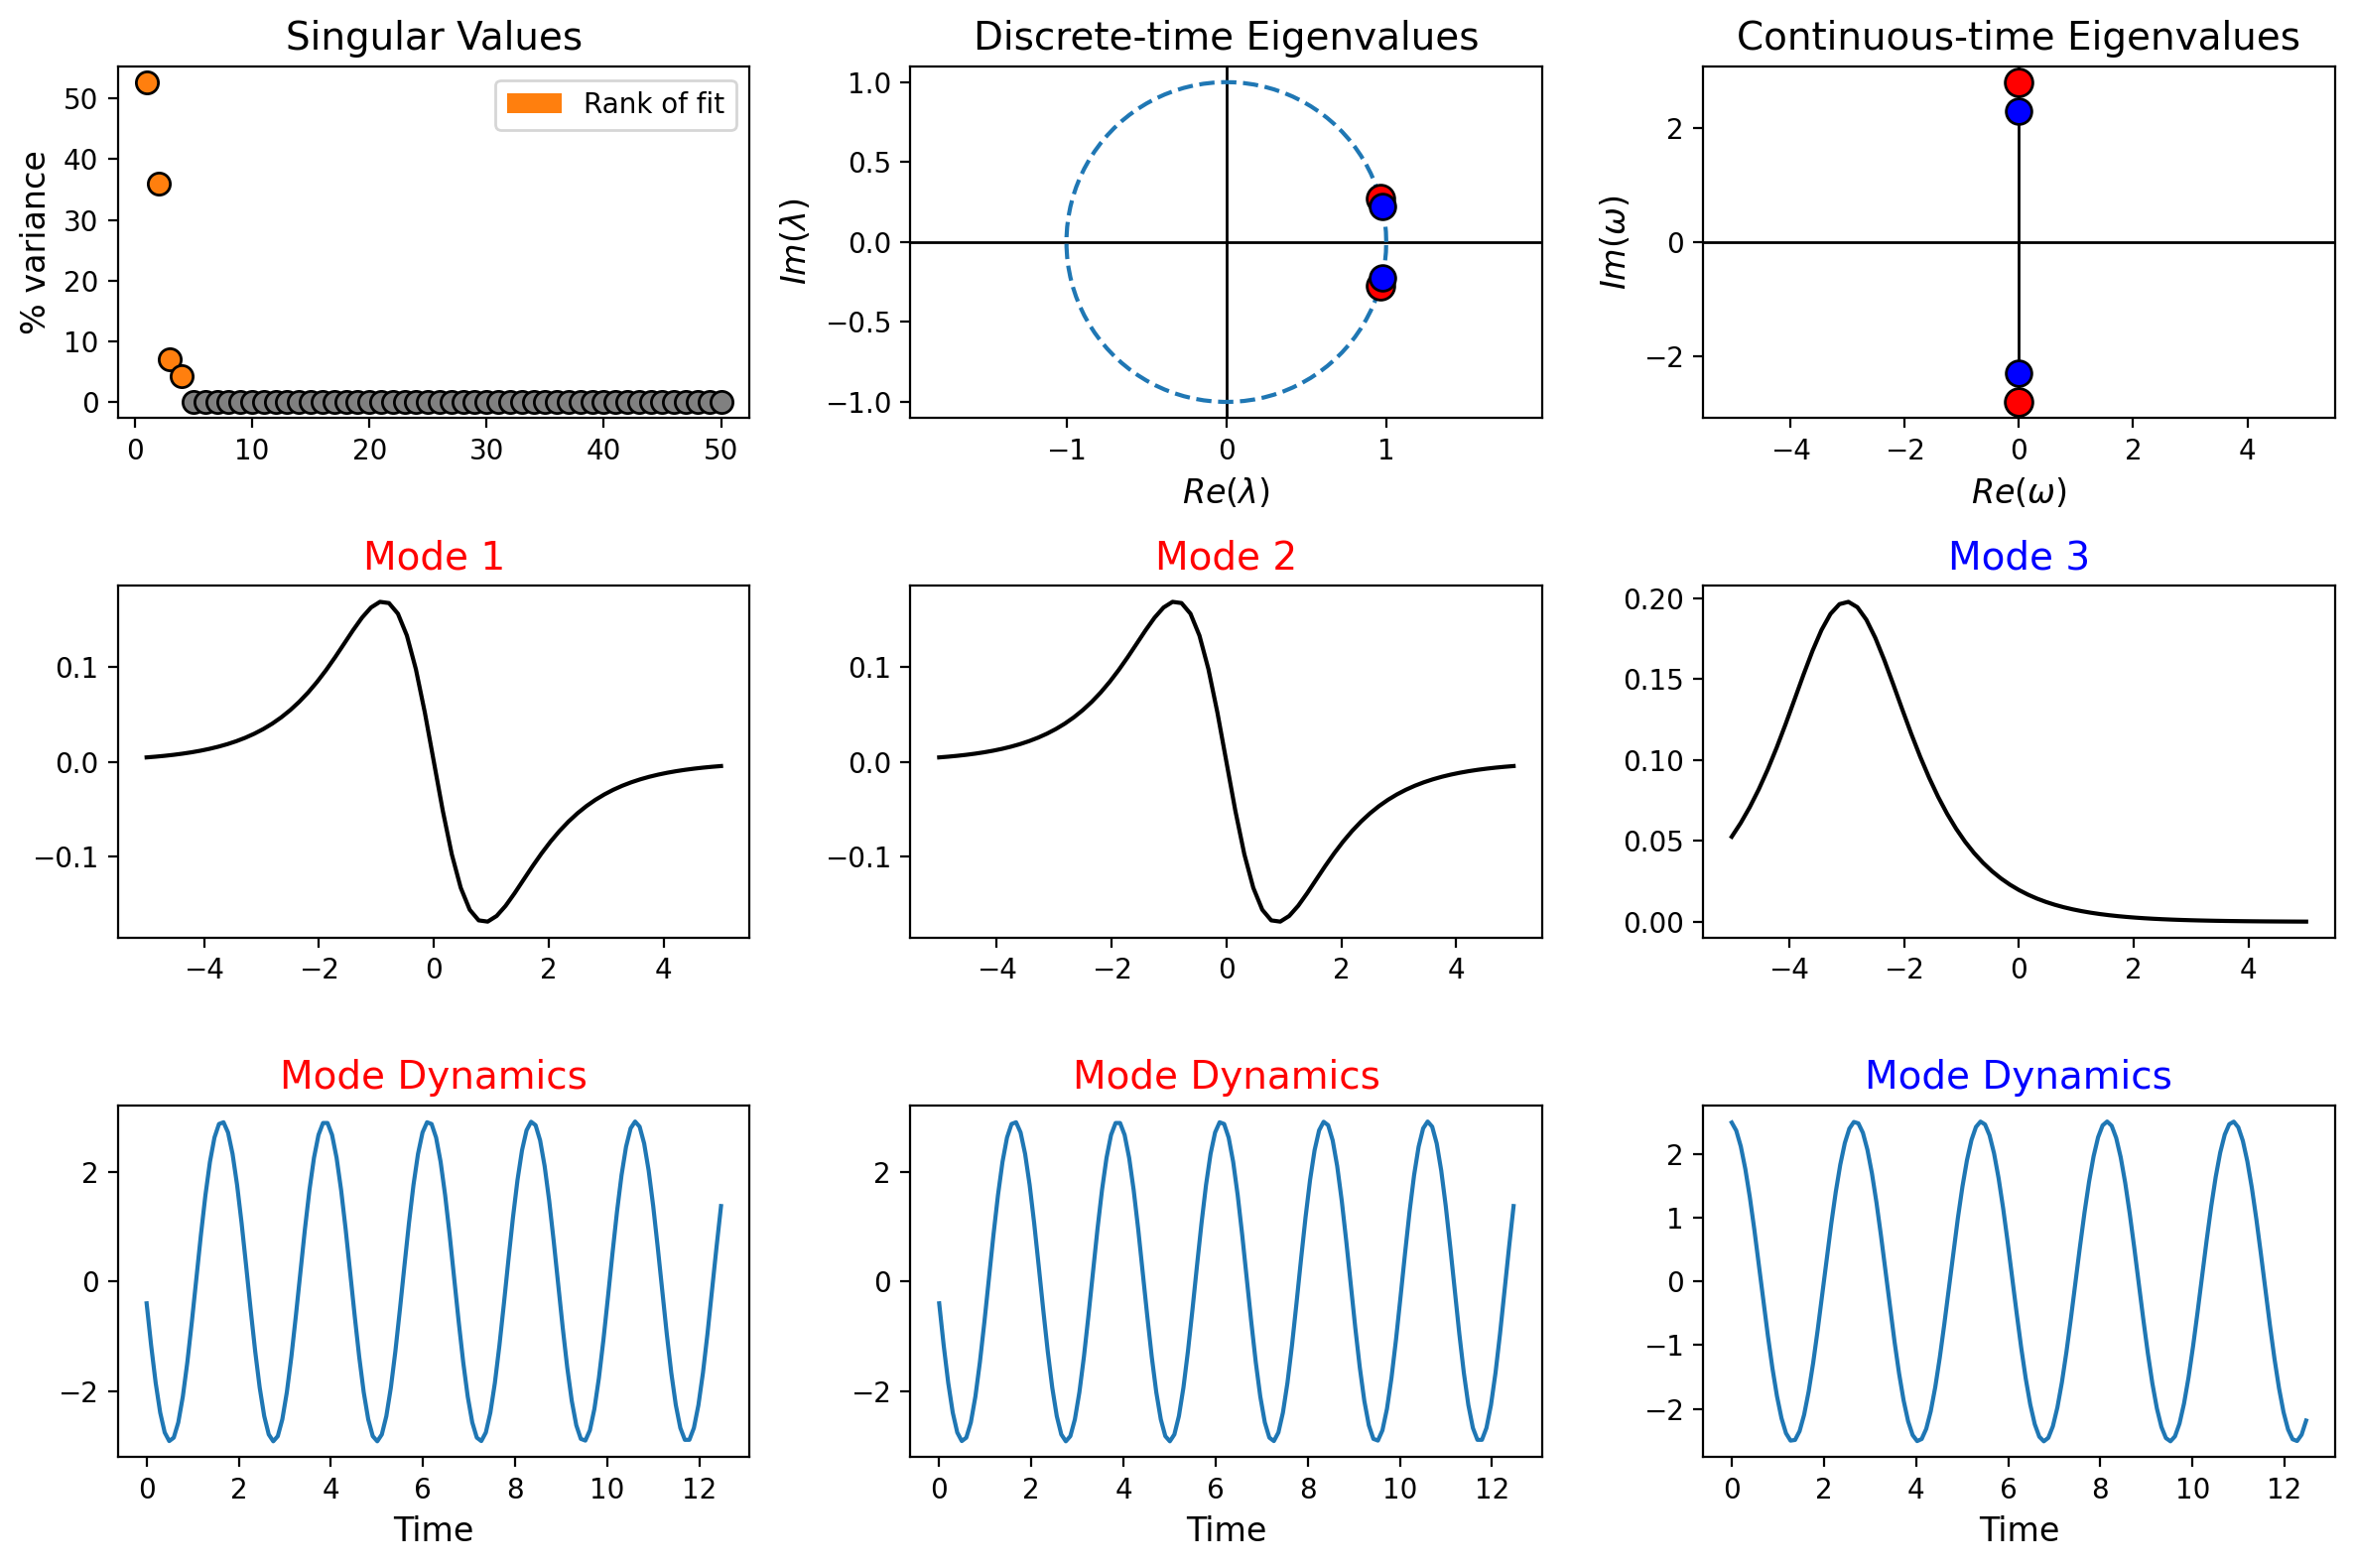

Frequencies (imaginary component): [-0.+2.8j -0.-2.8j -0.+2.3j -0.-2.3j]


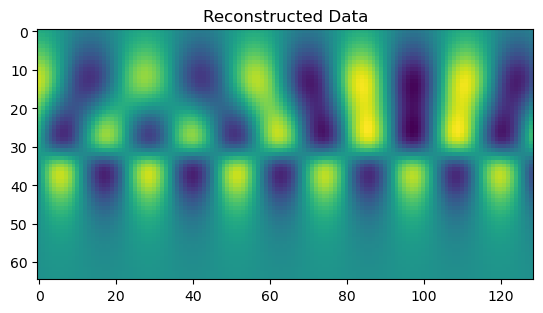

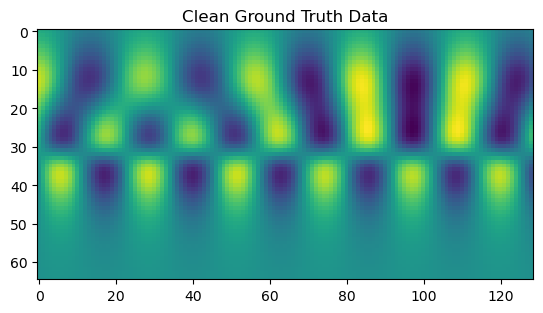

In [12]:
d = 2  # we will use this number of delays throughout the tutorial
dmd = DMD(svd_rank=4)
delay_dmd = hankel_preprocessing(dmd, d=d)
delay_dmd.fit(X.T)
plot_summary(delay_dmd, x=x, t=dt, d=d)
print(
    f"Frequencies (imaginary component): {np.round(np.log(delay_dmd.eigs) / dt, decimals=12)}"
)
plt.title("Reconstructed Data")
plt.imshow(delay_dmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()

In [23]:
X_full = X.T.copy()

### DMD By Scratch

In [37]:
n, m = X_full.T.shape
rank = 4

X = X_full[:,:-1]
Y = X_full[:,1:]

# SVD of X
U, S, Vh = np.linalg.svd(X)
S = np.diag(S)

# r rank of svd of X
U_r = U[:,:rank]
S_r = S[:rank,:rank]
Vh_r = Vh[:rank,:]

# Calculate A_tilde
U_r_star = U_r.conj().T
V_r = Vh_r.conj().T
S_r_inv = np.linalg.inv(S_r)

A_tilde = U_r_star @ Y @ V_r @ S_r_inv

# Eigendecomposition of A_tilde
eigs, W = np.linalg.eig(A_tilde)
Λ = np.diag(eigs)

# Koopman Modes & amplitudes
modes = Y @ V_r @ S_r_inv @ W
b, _, _, _ = np.linalg.lstsq(modes,X[:,0])

In [43]:
(modes @ np.diag(b) @ eigs).real

array([2.58421846e-01, 3.00144365e-01, 3.47786758e-01, 4.01725524e-01,
       4.62086765e-01, 5.28576857e-01, 6.00264294e-01, 6.75333292e-01,
       7.50865779e-01, 8.22755651e-01, 8.85894985e-01, 9.34750069e-01,
       9.64319549e-01, 9.71250746e-01, 9.54706079e-01, 9.16592819e-01,
       8.61045466e-01, 7.93405779e-01, 7.19128590e-01, 6.42963509e-01,
       5.68544545e-01, 4.98331487e-01, 4.33766152e-01, 3.75514300e-01,
       3.23708429e-01, 2.78150422e-01, 2.38461739e-01, 2.04182884e-01,
       1.74828766e-01, 1.49908319e-01, 1.28919925e-01, 1.11339376e-01,
       9.66198730e-02, 8.42165688e-02, 7.36308025e-02, 6.44532217e-02,
       5.63844947e-02, 4.92272918e-02, 4.28593157e-02, 3.72025693e-02,
       3.21993621e-02, 2.77981573e-02, 2.39475170e-02, 2.05949452e-02,
       1.76879309e-02, 1.51755425e-02, 1.30097956e-02, 1.11465508e-02,
       9.54595475e-03, 8.17252727e-03, 6.99501267e-03, 5.98609097e-03,
       5.12201959e-03, 4.38225223e-03, 3.74906389e-03, 3.20719842e-03,
      

In [45]:
delay_dmd